# Seq2Seq
Unlike the previous two notebooks, the material in this one (unless you've worked closely with NLP or the like) will likely be new to you. However, the main novelty can be summarized as follows: using RNNs in an encoder/decoder architecture.

Encoder/decoders come up *all* the time in deep learning, so it's useful to become familiar with the concept now: there are differences in implementation details of what the encoder and decoder sides looks like, but fundamentally this design pattern is quite common. Let's load in the data.

The data loading is more involved this time around, but we'll ignore the details for now. We will ultimately need to see how such work would translate to the AlphaFold case, but let's focus on the model for now:

In [1]:
import re
import os
import random
import pandas as pd
import numpy as np
import urllib.request
import unicodedata
import zipfile
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F

torch.manual_seed(0)

In [2]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

if not os.path.exists("data.zip"):
    url = "https://download.pytorch.org/tutorial/data.zip"
    urllib.request.urlretrieve(url, "data.zip")

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall(".")
    
input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

tensor_pairs = [tensorsFromPair(pair) for pair in pairs]

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je souffre encore a cause du decalage horaire .', 'i m still suffering from jet lag .']


The `Encoder` takes the data to a context, and the `Decoder` takes the corresponding context to a corresponding prediction of the word:

![](https://pytorch.org/tutorials/_images/seq2seq.png)

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        
    def forward(self, x, hidden):
        # x : N x T x D
        N, T, D = x.shape
        embedded = self.embedding(x).view(N, T, -1)
        _, hn = self.gru(embedded, hidden)
        return hn

Previously, we had the encoder simply taking in the input sentence, mappping that to a context vector, and directly being consumed by the decoder. However, there were two main issues with this. The first is simply that the context is *only* being fed in at the first step of the decoder. We hope that the hidden state of the decoder is retaining that context for future prediction, but it seems unlikely that long sequences will be capable of such retention. The second deficiency is that the context is fed in without any separation of *how* it is to be used per word prediction: the context is simply given, with the GRU expected to pry apart which parts are relevant per word.

To amend these deficiencies, we add this "attention" mechanism, which remedies the second issue. For the first, we simply feed in the encoded vector *per* prediction. Note that the encoder is *exactly* the same as it was previously: it's just that we now feed it into the decoder at each step of the prediction.

Recall the basic idea: we want to *attend* to the subsets of the encoded input that are relevant, with this "attention" vector just being a probability vector. The specific mechanism used to determine that weight will be some learned function of the previous word (since we expect the previous word to be relevant to where we should look) *and* also the hidden state (which conceptually contains a summary of all the previously encountered words). In other words, we believe the output sentence so far contains the relevant context of where we should pay attention in the input sentence. The use of the hidden state as opposed to the entire output sentence is likely just to reduce the number of parameters we need to learn and to better generalize, although this detail is not entirely clear to me.

To summarize: the encoder remains as was whereas the decoder now maps the `[x, hidden] -> attn_weights`, which then multiplies the encoded vector to give the attended encoded vector. This attended encoded vector now serves the role that the embedded vector previously served, namely as the first input to the GRU. This may seem a bit odd (after all, why perhaps would it not replace the `hidden` argument to the GRU), but just reemember that the hidden state needs to be retained for the "rolled context," and the first argument is supposed to be the specific point to use that context to predict. So, that's why the GRU's first argument now becomes the encoded context: it contains *exactly* the same information of `x` but in a more informative light. That is, instead of simply saying *what* the previous word was, it says what the relative context of thatword from the input was.

That's it! Nothing else changes.

In [5]:
class Decoder(nn.Module):
    def __init__(self, output_size, hidden_size):
        super(Decoder, self).__init__()
        
        self.attention = nn.Linear(2 * hidden_size, hidden_size)
        
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        
    def forward(self, x, hidden, encoded_input):
        N, T, D = x.shape
        embedded = self.embedding(x).view(N, T, -1)[:, 0, :] # N x H
        
        attention_inputs = torch.hstack([embedded, hidden]) # N x 2H
        attention = self.attention(attention_inputs) # N x T
        attention_weights = torch.nn.Softmax(attention) # N x H
        attended_input = torch.matmul() # (N x T x H)^T x (N x T x 1) -> (N x H x 1)
        
        output, hn = self.gru(embedded, hidden) # input[0]: [N x H x 1]
        output = self.out(output.view(1, -1))
        return output, hn

In [6]:
N = 1
H = 128

encoder = Encoder(input_lang.n_words, H)
decoder = Decoder(output_lang.n_words, H)

input_tensor = torch.stack([tensor_pairs[k][0] for k in range(10, 10 + N)])
init_hidden = torch.zeros((1, N, H))

encoded = encoder(input_tensor, init_hidden)

print(encoded)

tensor([[[-1.4702e-01,  4.1379e-01,  3.6360e-01,  6.2382e-02, -1.8443e-02,
           2.7656e-01, -2.2305e-01,  3.3506e-01, -6.0423e-02, -5.3020e-01,
          -1.1673e-01,  1.4360e-03, -4.9969e-01, -1.2383e-01,  3.8583e-02,
           4.5550e-04,  2.7990e-01,  4.5993e-01,  3.0449e-01,  2.7023e-01,
          -1.2698e-01, -2.5040e-01, -1.6139e-01, -5.4098e-01, -3.0216e-01,
          -1.0756e-01,  1.3527e-02, -1.3165e-01, -1.8842e-03,  3.8053e-02,
           2.4843e-02,  4.5525e-02,  2.6044e-01, -4.8941e-01, -5.0603e-02,
          -7.3428e-01, -2.4093e-01,  2.3459e-01,  8.3031e-02, -7.1811e-02,
           3.8970e-01,  2.3943e-01, -4.1332e-01, -5.9104e-02, -2.5092e-02,
           2.5156e-01, -3.5193e-02,  3.2591e-01,  7.0028e-02,  2.9215e-01,
          -3.4554e-01,  2.7159e-01,  8.5373e-02, -2.6173e-02,  7.2862e-02,
           8.1261e-02, -1.1153e-01, -3.4511e-01,  2.2750e-02,  5.2740e-02,
          -2.0742e-01, -1.5062e-01, -3.6496e-01,  7.8150e-02,  1.1871e-01,
           1.9632e-01, -6

In [7]:
N = 1
H = 128

encoder = Encoder(input_lang.n_words, H)
decoder = Decoder(output_lang.n_words, H)

input_tensor = torch.stack([tensor_pairs[k][0] for k in range(10, 10 + N)])
output_tensor = torch.stack([tensor_pairs[k][0] for k in range(10, 10 + N)])
init_hidden = torch.zeros((1, N, H))

encoded = encoder(input_tensor, init_hidden)
decoded, decoded_hn = decoder(output_tensor[:,0:1,:], encoded)

In [18]:
epochs = 200
N = 1
batch_size = 128
learning_rate = 0.01
teacher_forcing_prob = 0.75

tensor_pairs = np.array(tensor_pairs)

encoder = Encoder(input_lang.n_words, H)
decoder = Decoder(output_lang.n_words, H)

loss_criterion = nn.CrossEntropyLoss()
encoder_optim = optim.SGD(encoder.parameters(), lr=learning_rate)
decoder_optim = optim.SGD(decoder.parameters(), lr=learning_rate)

losses = []

for epoch in range(epochs):
    idx = np.random.choice(np.arange(len(tensor_pairs)), batch_size, replace=False)
    sample = tensor_pairs[idx]
    
    encoder_optim.zero_grad()
    decoder_optim.zero_grad()
    
    loss = 0
    
    for pair in sample:
        input_sentence = pair[0]
        output_sentence = pair[1]
        
        # context becomes first hidden state of decoder
        init_hidden = torch.zeros((1, N, H))
        hidden_enc = encoder(torch.unsqueeze(input_sentence, axis=0), init_hidden)
        
        prev_word = torch.tensor(np.array([[[SOS_token]]]))
        hidden_dec = hidden_enc
        for word in output_sentence:
            predicted_word_probs, hidden_dec = decoder(prev_word, hidden_dec)
            
            if random.random() < teacher_forcing_prob:
                prev_word_value = word
            else:
                prev_word_value = torch.argmax(predicted_word_probs)
            prev_word = torch.tensor(np.array([[[prev_word_value]]]))
            
            loss += loss_criterion(predicted_word_probs, word)
            
            if prev_word_value == EOS_token:
                break
    
    loss.backward()
    
    encoder_optim.step()
    decoder_optim.step()
    
    losses.append(loss.detach().numpy())
    
    print(f"Epoch : {epoch}/{epochs} -- Loss : {loss}")

/var/folders/4j/yb1phr856mgf1c7fysrq3_6c0000gs/T/ipykernel_14308/406562231.py:44: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  prev_word = torch.tensor(np.array([[[prev_word_value]]]))


Epoch : 0/200 -- Loss : 7426.76171875
Epoch : 1/200 -- Loss : 4514.91650390625
Epoch : 2/200 -- Loss : 7893.115234375
Epoch : 3/200 -- Loss : 21240.619140625
Epoch : 4/200 -- Loss : 10673.193359375
Epoch : 5/200 -- Loss : 22060.134765625
Epoch : 6/200 -- Loss : 23320.015625
Epoch : 7/200 -- Loss : 26930.8359375
Epoch : 8/200 -- Loss : 29868.751953125
Epoch : 9/200 -- Loss : 21693.046875
Epoch : 10/200 -- Loss : 25108.3515625
Epoch : 11/200 -- Loss : 32041.6015625
Epoch : 12/200 -- Loss : 39277.30078125
Epoch : 13/200 -- Loss : 28910.357421875
Epoch : 14/200 -- Loss : 21706.818359375
Epoch : 15/200 -- Loss : 16961.5859375
Epoch : 16/200 -- Loss : 19543.375
Epoch : 17/200 -- Loss : 22329.923828125
Epoch : 18/200 -- Loss : 24182.126953125
Epoch : 19/200 -- Loss : 20962.53515625
Epoch : 20/200 -- Loss : 21785.48046875
Epoch : 21/200 -- Loss : 13536.11328125
Epoch : 22/200 -- Loss : 16217.443359375
Epoch : 23/200 -- Loss : 13043.6455078125
Epoch : 24/200 -- Loss : 11083.033203125
Epoch : 25

Epoch : 199/200 -- Loss : 3410.563232421875


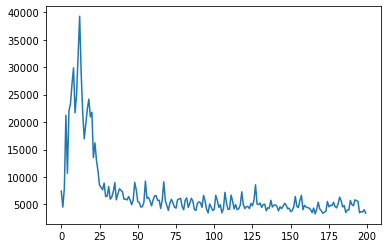

In [19]:
plt.plot(range(len(losses)), losses)
plt.show()

In [23]:
pair = random.choice(tensor_pairs) # 10, 15 : i'm
input_sentence = pair[0]
output_sentence = pair[1]
    
# context becomes first hidden state of decoder
init_hidden = torch.zeros((1, N, H))
hidden_enc = encoder(torch.unsqueeze(input_sentence, axis=0), init_hidden)

prev_word = torch.tensor(np.array([[[SOS_token]]]))
hidden_dec = hidden_enc

input_sentence_words = [input_lang.index2word[int(word_idx.numpy())] for word_idx in input_sentence]
output_sentence_words = [output_lang.index2word[int(word_idx.numpy())] for word_idx in output_sentence]
predicted_output_sentence = []

prev_word_value = None

while prev_word_value != EOS_token:
    predicted_word_probs, hidden_dec = decoder(prev_word, hidden_dec)
    prev_word_value = torch.argmax(predicted_word_probs) 
    prev_word = torch.tensor(np.array([[[prev_word_value]]]))

    predicted_output_sentence.append(output_lang.index2word[int(prev_word_value.numpy())])
                
    if prev_word_value == EOS_token:
        break

print(input_sentence_words)
print(output_sentence_words)
print(predicted_output_sentence)

['elle', 'est', 'presque', 'aussi', 'grande', 'que', 'vous', '.', 'EOS']
['she', 'is', 'almost', 'as', 'tall', 'as', 'you', '.', 'EOS']
['she', 's', 'not', 'very', 'the', '.', 'EOS']
